# 1. 데이터 라벨링
---
#### 1. Price Change Direction 
#### 2. Using Moving Average
#### 3. Local Min-Max
#### 4. Trend Scanning
---

### 임포트 및 데이터 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

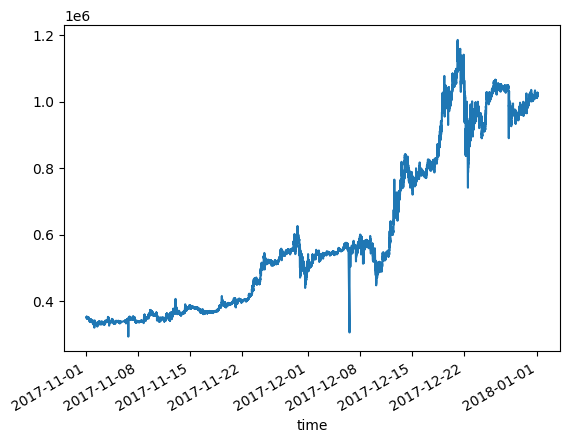

In [2]:
# 데이터 경로
DATA_PATH = '/Users/kenny/DS4/Project/Main_Quest/08_TimeSeries/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

### 1.1 Price Change Direction 적용하기

In [3]:

# window 지정
window = 10

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'].shift(window)) + 1) # modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal)

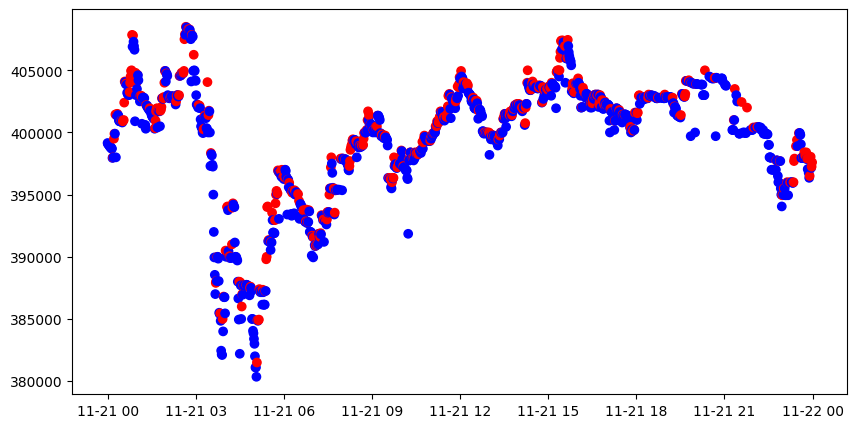

In [4]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21':'2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = modify_data.loc['2017-11-21':'2017-11-21', 'close']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig > c_sig.shift(1), 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### 1.2 Using Moving Average 적용하기

In [5]:

# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'].rolling(window).mean()) + 1) # modify_data['close'].rolling(window).mean() 활용

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal)

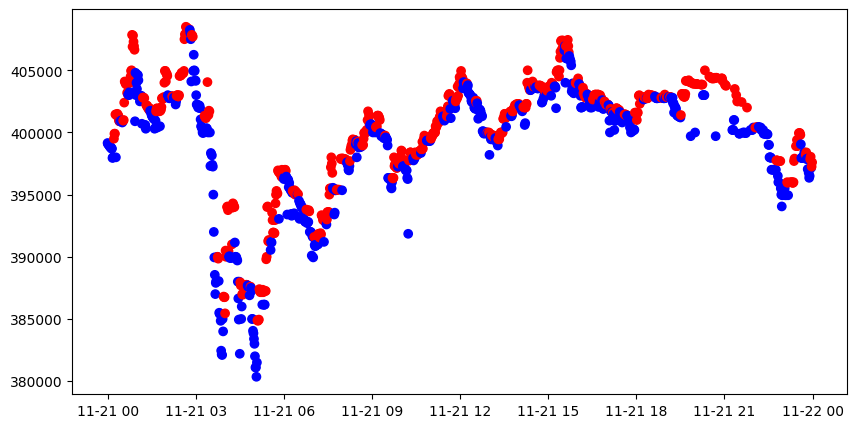

In [6]:

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21':'2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = modify_data.loc['2017-11-21':'2017-11-21', 'close']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig > c_sig.rolling(window).mean(), 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### 1.3 Local Min-Max 적용하기

In [7]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [8]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

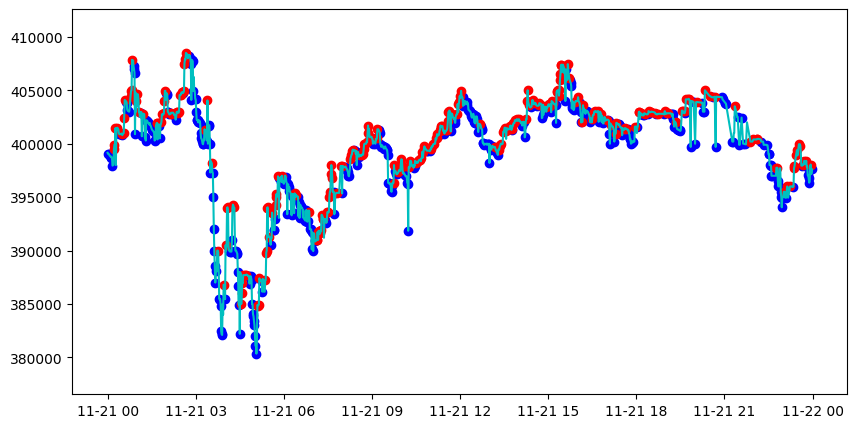

In [9]:

# subplots 및 plot 생성
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins['min_time'], mins['local_min'], c='blue', label='Local Min')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes['max_time'], maxes['local_max'], c='red', label='Local Max')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

### 1.4 rend Scanning 적용하기



In [10]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [11]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [12]:

# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [04:38<00:00, 119.95it/s]


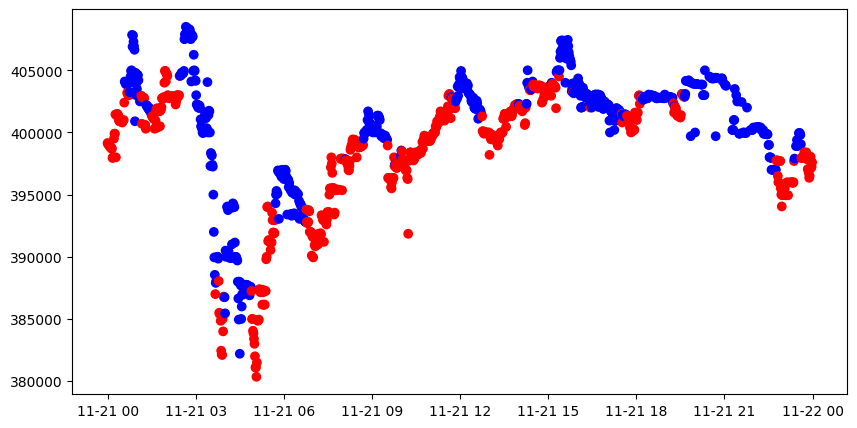

In [13]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# 2. 피쳐 엔지니어링

### 임포트 및 데이터 불러오기

In [14]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

# feature_importance 모듈 로딩
import importlib.util
fi_path = os.path.join(os.getcwd(), 'data', 'libs', 'feature_importance', 'importance.py')
spec = importlib.util.spec_from_file_location("importance", fi_path)
imp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(imp)

from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

print("모든 모듈이 성공적으로 로드되었습니다!")

모든 모듈이 성공적으로 로드되었습니다!


In [15]:
# 데이터 경로 설정
DATA_PATH = '/Users/kenny/DS4/Project/Main_Quest/08_TimeSeries/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

### 2.1 Technical Index 적용하기

In [16]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [17]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [18]:

df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [19]:

# RandomForest 모델 적용
rfc = RandomForestClassifier(random_state=42)

# RandomForest fit 하기
rfc.fit(X_sc, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 2.2 Feature Selection methods 적용하기

#### MDI, Mean Decrease Impurity

In [20]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.038952,0.001786
volume_fi,0.041285,0.002259
volume_mfi,0.048909,0.002927
volume_sma_em,0.035155,0.001705
volume_vpt,0.024173,0.001320
volatility_atr,0.076053,0.003280
volatility_ui,0.048765,0.002197
trend_macd_diff,0.084340,0.004327
trend_adx,0.052510,0.002194
trend_trix,0.066234,0.002759


#### MDA, Mean Decrease Accuracy

In [21]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [22]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

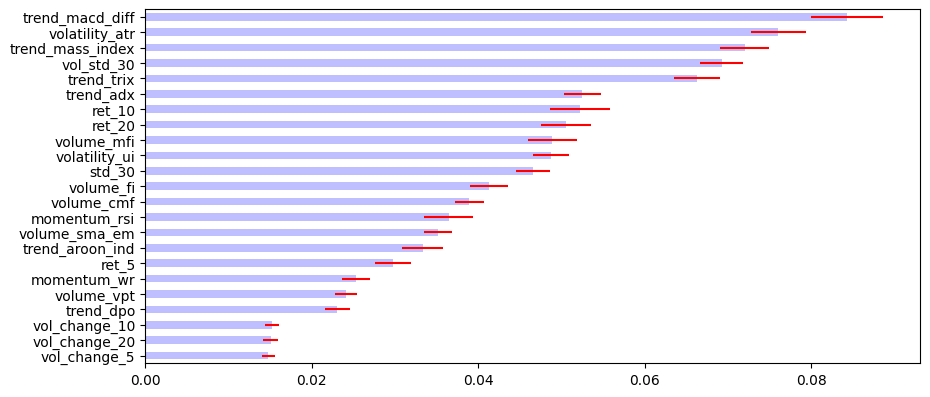

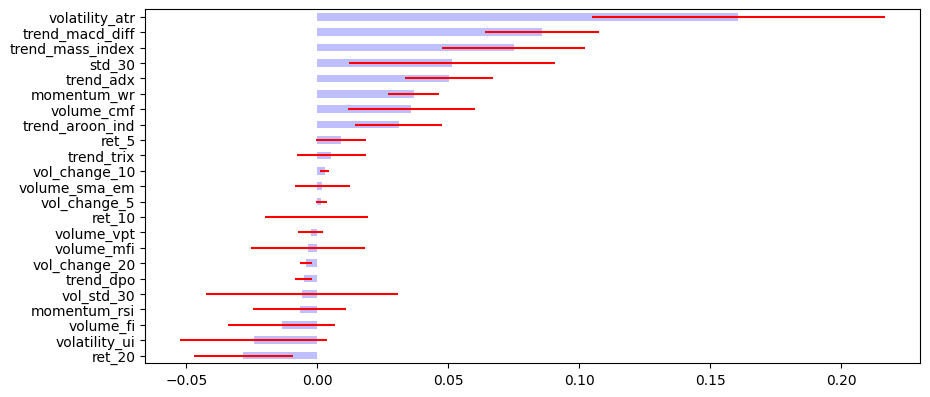

In [23]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

#### RFE CV, Recursive Feature Elimination

In [24]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=5) # RFECV
rfe_fitted = rfe_cv.fit(X_sc, y) # fit

In [25]:
# 선택된 피쳐 확인하기
selected_features = rfe_fitted.support_
selected_feature_names = X_sc.columns[selected_features]
print(f"선택된 피쳐 개수: {rfe_fitted.n_features_}")
print(f"선택된 피쳐들: {list(selected_feature_names)}")
print(f"피쳐 랭킹: {rfe_fitted.ranking_}")

선택된 피쳐 개수: 8
선택된 피쳐들: ['volume_fi', 'volatility_atr', 'trend_macd_diff', 'trend_aroon_ind', 'momentum_rsi', 'momentum_wr', 'ret_20', 'std_30']
피쳐 랭킹: [ 7  1  9  2  3  1  6  1 14  5  8 11  1  1  1 15 13 16 12 10  1  1  4]


#### SFS, Sequential Feature Selection

In [26]:
# SFS, Sequential Feature Selection

# RFE에서 선택된 피쳐 개수를 사용
n = rfe_fitted.n_features_
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [27]:
# 선택된 피쳐 확인하기
selected_features_sfs = sfs_fitted.support_
selected_feature_names_sfs = X_sc.columns[selected_features_sfs]
print(f"SFS로 선택된 피쳐 개수: {sfs_fitted.n_features_to_select}")
print(f"SFS로 선택된 피쳐들: {list(selected_feature_names_sfs)}")

SFS로 선택된 피쳐 개수: 8
SFS로 선택된 피쳐들: ['volume_fi', 'volume_mfi', 'trend_macd_diff', 'trend_adx', 'trend_dpo', 'ret_5', 'vol_change_10', 'vol_change_20']


# 3. 모델링

### 임포트 및 데이터 불러오기

In [28]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

# PKFold 모듈 직접 로딩
import importlib.util
pkfold_path = os.path.join(os.getcwd(), 'data', 'libs', 'mlutil', 'pkfold.py')
spec = importlib.util.spec_from_file_location("pkfold", pkfold_path)
pkfold_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pkfold_module)
PKFold = pkfold_module.PKFold

print("PKFold 모듈이 성공적으로 로드되었습니다!")

PKFold 모듈이 성공적으로 로드되었습니다!


In [29]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = './data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

# pickle 파일 불러오기
df_data = pd.read_pickle(data_file_name)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

### 3.1 Purged K-fold for Cross-Validation적용하기

In [31]:

n_cv = 5 # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.

t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_splits=n_cv, samples_info_sets=t1)

####   5를 선택한 이유: 
 ##### - 4보다 더 세밀한 교차검증이 가능하여 모델 성능을 더 정확히 평가할 수 있습니다.
 ##### - 1000개 데이터에서 각 fold당 200개씩 분할되어 충분한 학습/검증 데이터를 확보할 수 있습니다.
 ##### - 시계열 데이터의 특성상 너무 많은 fold는 시간적 연속성을 해칠 수 있으므로 적절한 균형점입니다.

### 3.2 Model 적용하기

In [32]:
bc_params = {'n_estimators': [10, 30, 50],
             'max_features': [0.3, 0.6, 0.8],
             'estimator__max_depth': [2, 7, 15],
             'estimator__max_features': ['sqrt', 'log2'],
             'estimator__min_samples_leaf': [1, 7, 15],
             'bootstrap_features': [True]
            }

In [33]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [34]:
# Bagging 적용
bag_rfc = BaggingClassifier(estimator=rfc, random_state=42)

In [35]:

# GridSearchCV 적용
gs_rfc = GridSearchCV(estimator=bag_rfc, param_grid=bc_params, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

In [36]:
# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


,estimator,"RandomForestC..., max_depth=7)"
,n_estimators,30
,max_samples,1.0
,max_features,0.3
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,0


In [37]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [ ]:

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y, average='weighted')
recall    = recall_score(test_y, pred_y, average='weighted')

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[37 12 30]
 [ 7 10 40]
 [ 0  5 50]]
정확도:0.5078534031413613, 정밀도:0.5783224919350575, 재현율:0.5078534031413613


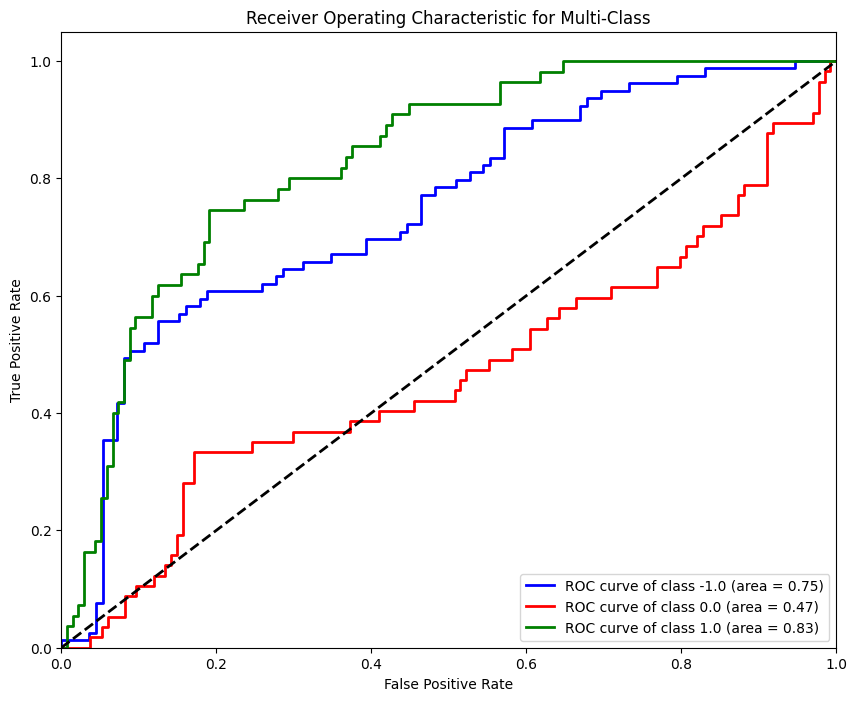

Macro-averaged One-vs-Rest ROC AUC score: 0.6814


In [41]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# 1. 모델의 예측 확률 구하기
# 이 코드는 이미 실행하셨겠지만, 명확성을 위해 포함합니다.
# gs_rfc_best 모델이 이미 학습되었다고 가정합니다.
prob_y = gs_rfc_best.predict_proba(test_x)

# 2. 실제 레이블(test_y)을 One-vs-Rest를 위해 바이너리 형태로 변환
# 모델의 클래스 순서에 맞게 변환합니다.
y_true_binarized = label_binarize(test_y, classes=gs_rfc_best.classes_)
n_classes = y_true_binarized.shape[1]

# 3. 각 클래스별로 ROC 커브 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # 클래스 i에 대한 ROC 커브 계산
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], prob_y[:, i])
    # 클래스 i에 대한 AUC 점수 계산
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. 모든 클래스의 ROC 커브를 한 번에 시각화
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green'] # 클래스별 색상 지정
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(gs_rfc_best.classes_[i], roc_auc[i]))

# 5. ROC 커브 기본 설정 (대각선 등)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

# (선택) 전체적인 성능을 하나의 숫자로 보고 싶을 때 (Macro Average AUC)
macro_roc_auc_ovr = roc_auc_score(test_y, prob_y, multi_class="ovr", average="macro")
print(f"Macro-averaged One-vs-Rest ROC AUC score: {macro_roc_auc_ovr:.4f}")
